In [2]:
import numpy as np
import pandas as pd
import os

### Surrogate

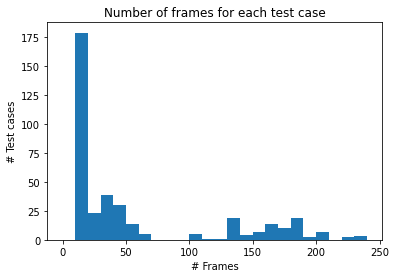

array([  0., 179.,  23.,  39.,  30.,  14.,   5.,   0.,   0.,   0.,   5.,
         1.,   1.,  19.,   4.,   7.,  14.,  10.,  19.,   2.,   7.,   0.,
         2.,   3.])

In [3]:
import matplotlib.pyplot as plt
data_folders = ['../data/routes_short_2023-05-31|16:26:55/']

image_folders = []
for data_folder in data_folders:
    for sub_folder in os.listdir(data_folder):
        if not sub_folder.endswith('.csv'): 
            image_folders.append(data_folder+sub_folder)
image_folders.sort()
image_folders = image_folders[:-1]

number_of_frames = []
tuple_frame_file = []
for image_folder in image_folders:
    number_of_frames.append(len(os.listdir(image_folder+"/bev")))
    tuple_frame_file.append((len(os.listdir(image_folder+"/bev")), image_folder+"/bev"))

bins = plt.hist(number_of_frames, bins=range(0,250,10))
plt.title("Number of frames for each test case")
plt.ylabel('# Test cases')
plt.xlabel('# Frames')
plt.show()
bins[0]

(390, 14)


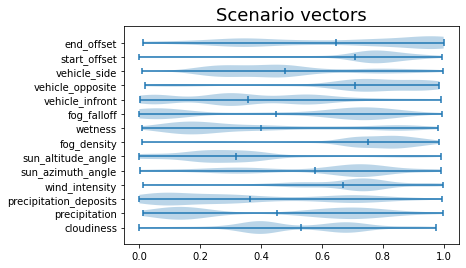

In [4]:
scenario_header = ["cloudiness",
                   "precipitation",
                   "precipitation_deposits",
                   "wind_intensity",
                   "sun_azimuth_angle",
                   "sun_altitude_angle",
                   "fog_density",
                   "wetness",
                   "fog_falloff",
                   "vehicle_infront", 
                   "vehicle_opposite", 
                   "vehicle_side",
                   "start_offset",
                   "end_offset"]
scenarios = pd.read_csv(data_folders[0]+'scenario.csv',names=scenario_header)
for i in range(1, len(data_folders)):
    scenarios = pd.concat([scenarios, pd.read_csv(data_folders[i]+'scenario.csv',names=scenario_header)])
print(scenarios.shape)
        
# plt.figure(figsize=(20,2))
plt.violinplot(scenarios, vert=False, showmeans=True, widths=0.9)
plt.yticks(range(1,15), scenario_header)
plt.title("Scenario vectors", fontsize=18)
plt.show()

In [5]:
criterion_header = ["RouteCompletionTest",   
                    "RouteCompletionTest_figure",
                    "OutsideRouteLanesTest", 
                    "OutsideRouteLanesTest_figure",
                    "CollisionTest",         
                    "CollisionTest_figure",
                    "RunningRedLightTest",   
                    "RunningRedLightTest_figure",
                    "RunningStopTest",       
                    "RunningStopTest_figure",
                    "InRouteTest", 
                    "InRouteTest_figure",          
                    "AgentBlockedTest",
                    "AgentBlockedTest_figure",      
                    "Timeout"]
criterions = pd.read_csv(data_folders[0]+'criterion.csv',names=criterion_header)
for i in range(1, len(data_folders)):
    criterions = pd.concat([criterions, pd.read_csv(data_folders[i]+'criterion.csv',names=criterion_header)])
print(criterions.shape)

(390, 15)


In [7]:
criterion_bool_head = ["RouteCompletionTest",   
                        "OutsideRouteLanesTest", 
                        "CollisionTest",         
                        "RunningRedLightTest",   
                        "RunningStopTest",       
                        "InRouteTest", 
                        "AgentBlockedTest",
                        "Timeout"]
print(len(criterions))
(criterions[criterion_bool_head] == 1).sum()

390


RouteCompletionTest      296
OutsideRouteLanesTest    286
CollisionTest            199
RunningRedLightTest        0
RunningStopTest            0
InRouteTest                0
AgentBlockedTest           0
Timeout                   97
dtype: int64

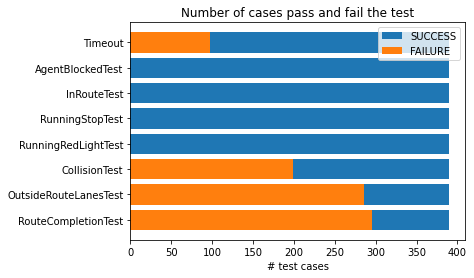

In [8]:
import matplotlib.pyplot as plt

plt.barh(criterion_bool_head, [criterions.shape[0]]*8)
plt.barh(criterion_bool_head, (criterions[criterion_bool_head] == 1).sum())
plt.legend(['SUCCESS','FAILURE'])
plt.title('Number of cases pass and fail the test')
plt.xlabel('# test cases')
plt.show()

(-0.3391, 0.6153)


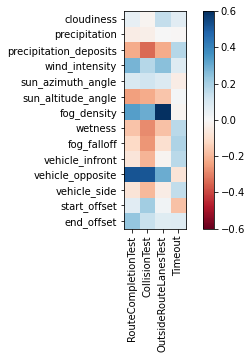

In [10]:
select_criterions = ["RouteCompletionTest", 
                     "CollisionTest", 
                     "OutsideRouteLanesTest", 
                     "Timeout"] 

scenario_criterion = pd.concat([scenarios, criterions[select_criterions]],axis=1)

print("({}, {})".format(round(scenario_criterion.corr().to_numpy()[:14, 14:18].min(), 4), 
                        round(scenario_criterion.corr().to_numpy()[:14, 14:18].max(), 4)))

plt.imshow(scenario_criterion.corr().to_numpy()[:14, 14:18], cmap='RdBu', vmin=-0.6, vmax=0.6)
plt.yticks(range(14),scenario_criterion.columns.tolist()[:14])
plt.xticks(range(4),scenario_criterion.columns.tolist()[14:18],rotation=90)
plt.colorbar()
plt.show()
# Positive means easy to cause failure

In [11]:
importance = []
for i, name in enumerate(scenario_criterion.columns.tolist()[:14]):
    importance.append((sum(scenario_criterion.corr().to_numpy()[:14, 14:18][i]**2)**0.5, name))
importance.sort()
importance

[(0.056515181500619245, 'precipitation'),
 (0.16741827138767915, 'cloudiness'),
 (0.17543670961418, 'sun_azimuth_angle'),
 (0.2584498898036552, 'vehicle_side'),
 (0.2692863575013832, 'vehicle_infront'),
 (0.2811275133438143, 'start_offset'),
 (0.28914196452626506, 'end_offset'),
 (0.35661970951436117, 'fog_falloff'),
 (0.372739038316715, 'sun_altitude_angle'),
 (0.40757497971087736, 'wetness'),
 (0.42174013964620116, 'wind_intensity'),
 (0.4946308384378401, 'precipitation_deposits'),
 (0.7585953488115208, 'fog_density'),
 (0.790837897944788, 'vehicle_opposite')]

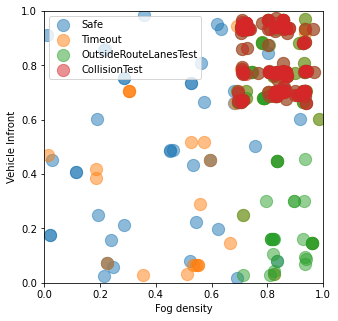

In [12]:
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt

# X = scenario_criterion[scenario_criterion.columns.tolist()[:14]].to_numpy()
# pca = PCA(n_components=2)
# # pca = PCA()
# pca.fit(X)

test_target = ['RouteCompletionTest','Timeout','OutsideRouteLanesTest','CollisionTest']
factors = ['fog_density', 'vehicle_opposite']

# colors = ['#BCCBE5', '#FFD5AB', '#FFCCC3', '#B1D0A9', '#C1BCBF', '#E5CDCC']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
s=150 
alpha = 0.5

# Plot
success_case = scenario_criterion[test_target].sum(axis=1) == 0
plt.figure(figsize=(5,5))
plt.scatter(scenario_criterion[factors[0]][success_case], 
            scenario_criterion[factors[1]][success_case],
            c = colors[0], s=s, alpha=alpha)

for i, certion_label in enumerate(test_target[1:]):
    plt.scatter(scenario_criterion[factors[0]][(scenario_criterion[certion_label] == 1)], 
                scenario_criterion[factors[1]][(scenario_criterion[certion_label] == 1)],
                c = colors[i+1], s=s, alpha=alpha)


plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(['Safe']+test_target[1:])

plt.xlabel('Fog density')
plt.ylabel('Vehicle Infront')

plt.show()

### Surrogate vs NSGA

In [2]:
NSGA_data      = '../data/routes_short_2023-05-29|15:33:07/'
surrogate_data = '../data/routes_short_2023-05-31|16:26:55/'

criterion_header = ["RouteCompletionTest",   
                    "RouteCompletionTest_figure",
                    "OutsideRouteLanesTest", 
                    "OutsideRouteLanesTest_figure",
                    "CollisionTest",         
                    "CollisionTest_figure",
                    "RunningRedLightTest",   
                    "RunningRedLightTest_figure",
                    "RunningStopTest",       
                    "RunningStopTest_figure",
                    "InRouteTest", 
                    "InRouteTest_figure",          
                    "AgentBlockedTest",
                    "AgentBlockedTest_figure",      
                    "Timeout"]

criterion_bool_head = ["RouteCompletionTest",   
                        "OutsideRouteLanesTest", 
                        "CollisionTest",         
                        # "RunningRedLightTest",   
                        # "RunningStopTest",       
                        # "InRouteTest", 
                        # "AgentBlockedTest",
                        "Timeout"]

scenario_header = ["cloudiness",
                   "precipitation",
                   "precipitation_deposits",
                   "wind_intensity",
                   "sun_azimuth_angle",
                   "sun_altitude_angle",
                   "fog_density",
                   "wetness",
                   "fog_falloff",
                   "vehicle_infront", 
                   "vehicle_opposite", 
                   "vehicle_side",
                   "start_offset",
                   "end_offset"]

select_criterions = ["RouteCompletionTest", 
                     "CollisionTest", 
                     "OutsideRouteLanesTest", 
                     "Timeout"] 

NSGA_criterions = pd.read_csv(NSGA_data+'criterion.csv',names=criterion_header)
NSGA_scenarios  = pd.read_csv(NSGA_data+'scenario.csv',names=scenario_header)
surrogate_criterions = pd.read_csv(surrogate_data+'criterion.csv',names=criterion_header)
surrogate_scenarios  = pd.read_csv(surrogate_data+'scenario.csv',names=scenario_header)

print(NSGA_criterions.shape)
print(surrogate_criterions.shape)
print(NSGA_scenarios.shape)
print(surrogate_scenarios.shape)


(390, 15)
(390, 15)
(390, 14)
(390, 14)


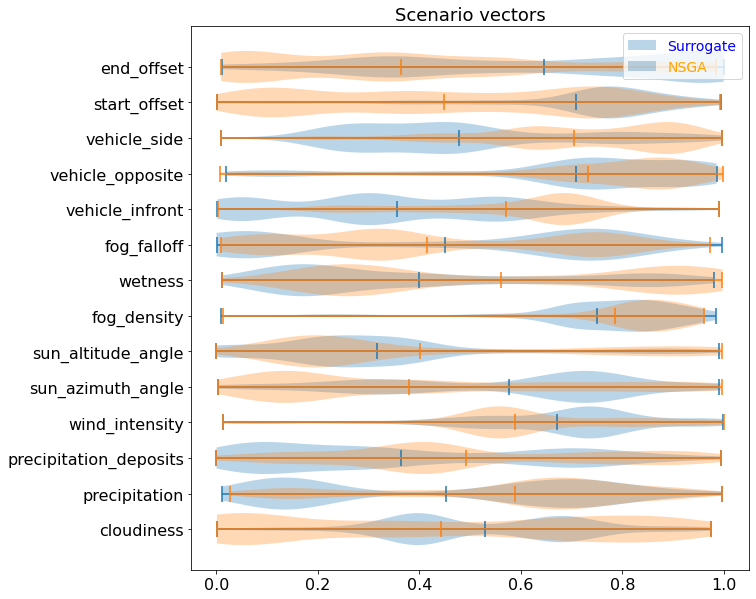

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.violinplot(surrogate_scenarios, vert=False, showmeans=True, widths=0.9)
plt.violinplot(NSGA_scenarios, vert=False, showmeans=True, widths=0.9)
plt.yticks(range(1, 15), scenario_header,fontsize=16)
plt.xticks(fontsize=16)
plt.title("Scenario vectors", fontsize=18)
plt.legend(['Surrogate','NSGA'],labelcolor=['blue','orange'],fontsize=14)

plt.show()

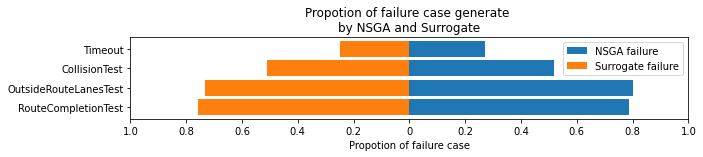

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,1.5))
plt.barh(criterion_bool_head, (NSGA_criterions[criterion_bool_head] == 1).sum()/len(NSGA_criterions))
plt.barh(criterion_bool_head, -(surrogate_criterions[criterion_bool_head] == 1).sum()/len(surrogate_criterions))
plt.legend(['NSGA failure','Surrogate failure'])
plt.title('Propotion of failure case generate \nby NSGA and Surrogate')
plt.xlabel('Propotion of failure case')
plt.xticks(np.arange(-1,1.2,0.2),[1.0,0.8,0.6,0.4,0.2,0,0.2,0.4,0.6,0.8,1.0])
plt.show()

(-0.3391, 0.6153)
(-0.3087, 0.7539)


/home/guannan/miniconda3/envs/TCP/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


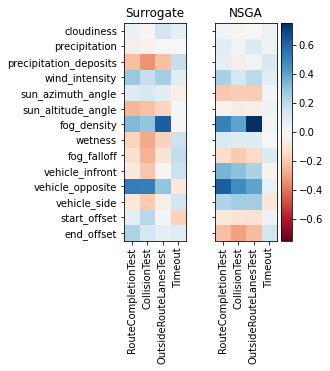

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3.2, 4), sharey=True)


ax1.set_title('Surrogate')
scenario_criterion = pd.concat([surrogate_scenarios, surrogate_criterions[select_criterions]],axis=1)
print("({}, {})".format(round(scenario_criterion.corr().to_numpy()[:14, 14:18].min(), 4), 
                        round(scenario_criterion.corr().to_numpy()[:14, 14:18].max(), 4)))
fig1 = ax1.imshow(scenario_criterion.corr().to_numpy()[:14, 14:18], cmap='RdBu', vmin=-0.75, vmax=0.75)
# plt.yticks(range(14),scenario_criterion.columns.tolist()[:14])
# plt.xticks(range(4),scenario_criterion.columns.tolist()[14:18],rotation=90)

ax2.set_title('NSGA')
scenario_criterion = pd.concat([NSGA_scenarios, NSGA_criterions[select_criterions]],axis=1)
print("({}, {})".format(round(scenario_criterion.corr().to_numpy()[:14, 14:18].min(), 4), 
                        round(scenario_criterion.corr().to_numpy()[:14, 14:18].max(), 4)))
fig2 = ax2.imshow(scenario_criterion.corr().to_numpy()[:14, 14:18], cmap='RdBu', vmin=-0.75, vmax=0.75)

ax1.set_yticks(range(14),scenario_criterion.columns.tolist()[:14])
ax1.set_xticks(range(4),scenario_criterion.columns.tolist()[14:18],rotation=90)
ax2.set_xticks(range(4),scenario_criterion.columns.tolist()[14:18],rotation=90)
# plt.yticks([])
# plt.xticks(range(4),scenario_criterion.columns.tolist()[14:18],rotation=90)
fig.colorbar(fig1, cmap='RdBu')

plt.show()

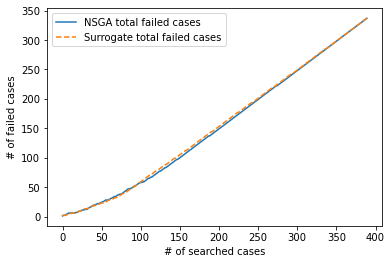

In [6]:
import matplotlib.pyplot as plt

select_criterions = ['RouteCompletionTest', 'CollisionTest', 'OutsideRouteLanesTest', 'Timeout']

def get_sum_overtime(array):
    result = []
    sum = 0
    for data in array:
        sum += data
        result.append(sum)
    return result

fig, ax = plt.subplots()
ax.plot(range(len(NSGA_criterions)), get_sum_overtime(NSGA_criterions[select_criterions].sum(axis=1) > 0), label='NSGA total failed cases')
ax.plot(range(len(NSGA_criterions)), get_sum_overtime(surrogate_criterions[select_criterions].sum(axis=1) > 0 ), '--', label='Surrogate total failed cases')

plt.xlabel('# of searched cases')
plt.ylabel('# of failed cases')
plt.legend()
plt.show()

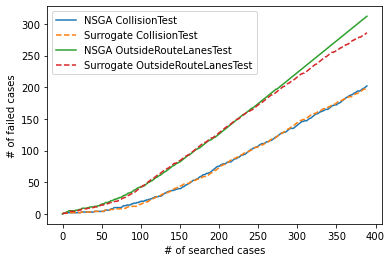

In [7]:
import matplotlib.pyplot as plt

select_criterions = ['CollisionTest', 'OutsideRouteLanesTest']

def get_sum_overtime(array):
    result = []
    sum = 0
    for data in array:
        sum += data
        result.append(sum)
    return result

fig, ax = plt.subplots()
for criterion in select_criterions:
    ax.plot(range(len(NSGA_criterions)), get_sum_overtime(NSGA_criterions[criterion]), label='NSGA '+criterion)
    ax.plot(range(len(NSGA_criterions)), get_sum_overtime(surrogate_criterions[criterion]), '--', label='Surrogate '+criterion)

plt.xlabel('# of searched cases')
plt.ylabel('# of failed cases')
plt.legend()
plt.show()

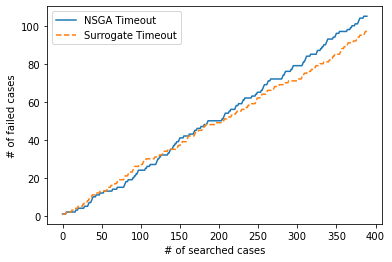

In [8]:
import matplotlib.pyplot as plt

select_criterions = ['Timeout']

def get_sum_overtime(array):
    result = []
    sum = 0
    for data in array:
        sum += data
        result.append(sum)
    return result

fig, ax = plt.subplots()
for criterion in select_criterions:
    ax.plot(range(len(NSGA_criterions)), get_sum_overtime(NSGA_criterions[criterion]), label='NSGA '+criterion)
    ax.plot(range(len(NSGA_criterions)), get_sum_overtime(surrogate_criterions[criterion]), '--', label='Surrogate '+criterion)

plt.xlabel('# of searched cases')
plt.ylabel('# of failed cases')
plt.legend()
plt.show()

2. fitness score
5. GA last generation for test case
4. increase the serach space of GA
1. Straight Road
3. MLP for surrogate model